## Data gridding

In [1]:
from GG_mthesis import *
%matplotlib inline

In [2]:
# sns.set_style('whitegrid')
# sns.set_palette('colorblind')
# sns.set(font_scale=1.2)

In [3]:
#define the path
path = '.\\data\\02_intermediate\\tsg_orchestra_return\\b1903933_preprocessed_return.nc'

#open the dataset with the defined path
ds = xr.open_dataset(path) 

In [4]:
#doesnt really work
#ds['time1'] = xr.DataArray(np.array(ds.time), dims='time')
#ds.time1.attrs = {'long_name': 'Chronological DateTime Date',
 #'standard_name': 'time',
 #'ancillary_variables': 'TIME_SEADATANET_QC',
 #'axis': 'T',
 #'valid_min': 0.0,
 #'valid_max': 2500000.0,
 #'sdn_parameter_urn': 'SDN:P01::CJDY1101',
 #'sdn_parameter_name': 'DateTime (chronological)',
 #'sdn_uom_name': 'Days',
 #'sdn_uom_urn': 'SDN:P06::UTAA'}

In [5]:
#First I create the relevant grid (start to end, 500m steps).
distance_grid = np.arange(0, float(np.max(ds.distance_cum)), 500)

#Make the cumulative distance the dimension as I want to use it as the interpolating dimension
ds = ds.swap_dims({'time':'distance_cum'})

#Here I create new gridded dataset, one with a linear interpolation and another one with a cubic interpolation.
ds_gridded = ds.interp(distance_cum = distance_grid, method='linear')
#ds_gridded_cubic = ds.interp(distance_cum = distance_grid, method='cubic')

In [6]:
ds_gridded

<xarray.Dataset>
Dimensions:                 (distance_cum: 709)
Coordinates:
    lat                     (distance_cum) float64 -57.87 -57.87 ... -55.04
    lon                     (distance_cum) float64 -56.55 -56.56 ... -58.0 -58.0
    depth                   (distance_cum) float64 6.5 6.5 6.5 ... 6.5 6.5 6.5
  * distance_cum            (distance_cum) float64 0.0 500.0 ... 3.54e+05
Data variables: (12/21)
    crs                     (distance_cum) float64 0.0 0.0 0.0 ... 0.0 0.0 0.0
    SDN_EDMO_CODE           (distance_cum) float64 43.0 43.0 43.0 ... 43.0 43.0
    SDN_BOT_DEPTH           (distance_cum) float64 nan nan nan ... nan nan nan
    POSITION_SEADATANET_QC  (distance_cum) float64 49.0 49.0 49.0 ... 49.0 49.0
    DEPTH_SEADATANET_QC     (distance_cum) float64 49.0 49.0 49.0 ... 49.0 49.0
    TIME_SEADATANET_QC      (distance_cum) float64 49.0 49.0 49.0 ... 49.0 49.0
    ...                      ...
    T                       (distance_cum) float64 2.626 2.642 ... 7.744 7.747
    distance_aux            (distance_cum) float64 389.8 391.4 ... 364.9 354.8
    pressure                (distance_cum) float64 6.561 6.561 ... 6.559 6.559
    SA                      (distance_cum) float64 33.98 33.97 ... 34.1 34.1
    CT                      (distance_cum) float64 2.632 2.648 ... 7.751 7.755
    rho_pot                 (distance_cum) float64 1.027e+03 ... 1.026e+03
Attributes:
    date_update:  2020-07-31T01:05:54+0100
    comment:      
    Conventions:  SeaDataNet_1.0 CF-1.6
    featureType:  trajectory
    title:        SeaDataNet NETCDF TRAJECTORY Climate Forecast 1.6 - GENERAT...

In [7]:
ds_gridded.rho_pot.mean()

<xarray.DataArray 'rho_pot' ()>
array(1026.63166237)

In [7]:
#Let's calculate the buoyancy at each point
g = 9.81 #m s-2
rho_0 = 1027 #kg m-3

#from Vallis the buoyancy is related to density through: b = -g delta(rho)/rho_0
ds_gridded['b'] = -(g/rho_0)*(ds_gridded.rho_pot-rho_0)
ds_gridded['b'].attrs = {
    'long_name': 'buoyancy',
    'standard_name': 'b',
    'units': 'N',
    'description': 'Sea pressure from height using gsw.'}



In [8]:
#The horizontal buoyancy gradient then is:
bx = []
for i in range(len(ds_gridded.b)-1):
    bx.append((ds_gridded.b[i+1] - ds_gridded.b[i])/1000)
#As the submesoscale fronts are anisotropic, we are not interested in the sign and can take the absolute value.
bx = np.abs(bx)

[Text(0.5, 0, 'Distance (km)'),
 Text(0, 0.5, 'Horizontal buoyancy gradient ($s^{-2}$)')]

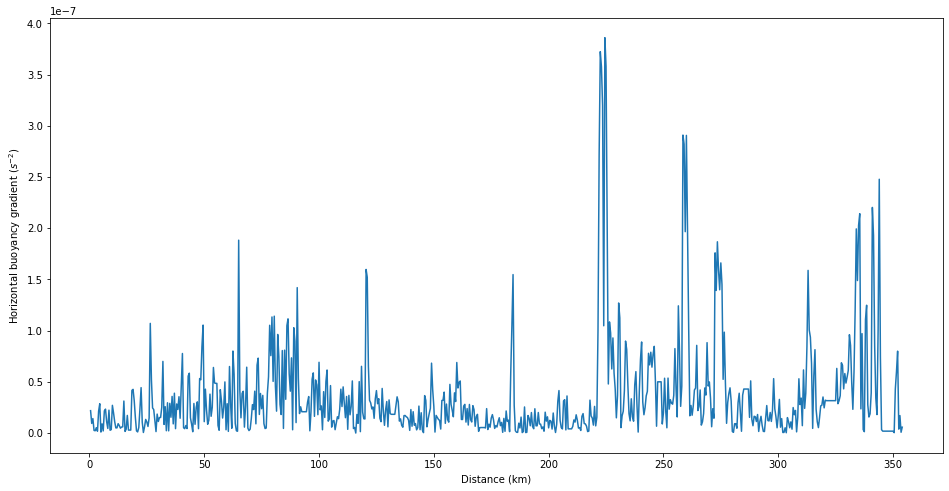

In [9]:
fig, ax = plt.subplots(figsize=(16,8))

sns.lineplot(x=ds_gridded.distance_cum[1:]/1000, y=bx)
ax.set(xlabel='Distance (km)', ylabel='Horizontal buoyancy gradient ($s^{-2}$)')

In [11]:
#We can safe the gridded data with the calculated buoyancy gradient.
path_to = '.\\data\\03_processed\\tsg_orchestra_return\\b1903933_gridded_return.nc'
ds_gridded.to_netcdf(path_to)